# Evaluating a diffusion model using a CNN

In [1]:
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# util files
from unet import SimpleUNet
from cnn import CNN

# other imports
from pathlib import Path
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class NormalizeTransform(nn.Module):
    """
    Transform that normalizes 1xnxn tensors to [0, 1]
    Works with dict input/output

    Taken from PyML course
    """
    def __init__(self):
        super(NormalizeTransform, self).__init__()

    def forward(self, data):
        """
        Args:
            data: dict with 'image' key containing torch.Tensor of shape (1, n, n)
        Returns:
            dict with normalized image in range [0, 1]
        """
        image = data[0]
        data[0] = (image - image.min()) / (image.max() - image.min() + 1e-8)
        return data

transform_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(14),
    NormalizeTransform()
])
data = "mnist"
train_dataset = datasets.MNIST(root=os.path.join("data", data), download=True, train=True, transform=transform_list)
wanted_class = 2
wanted_class_dataset = [d for d in train_dataset if d[1] == wanted_class]
wanted_class_loader = DataLoader(dataset=wanted_class_dataset, batch_size=64, shuffle=True)

In [1]:
plt.imshow(1 - wanted_class_dataset[1][0].squeeze(), cmap="gray")
plt.title("Class we are training on")
plt.show()


NameError: name 'plt' is not defined

In [5]:
class DDPMDiffusion:

    def __init__(
        self,
        time_steps: int, #discrete denoising steps in the diffusion process
        beta_start: float,
        beta_end: float,
        device: str='cpu',
    ):
        """
        This class handles the forward and the backward process of our diffusion model.
        Taken from PyML course.
        Args:
            time_steps: Maximum number of timesteps T
            beta_start: starting point of the noise schedule (how much noise we add at the first step)
            beta_end: end point of the noise schedule (how much noise we add at the last step)
            device: the device we use for training
        """

        # save arguments
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)


    def diffuse(self, x: torch.Tensor, noise: torch.tensor, t: int):

        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None] # add dimensions to fit data
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]

        x_t = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

        return x_t

    def denoise(
        self,
        model: nn.Module,
        num_samples: int,
        channels,
        img_size,
    ): #

        model.eval()
        with torch.inference_mode():

            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)

            collect = []

            for i in tqdm(reversed(range(self.time_steps))):
                # create a tensor of timesteps
                t = (torch.ones(num_samples) * i).long().to(self.device)

                pred_noise = model(x, t) #

                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    # if i==0 -> we we are at x_0, then don't add noise
                    noise = torch.zeros_like(x)

                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise

                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

In [6]:
ddpm_diffusion_model = DDPMDiffusion(time_steps=1000, beta_start=0.0001, beta_end=0.02, device=device)
loss_fn = nn.MSELoss()

## Train and save model(s)

In [7]:
n_epochs = 50

model_name = ""
trained_epochs = 0
path = os.path.join(os.getcwd(), "saved_data", data, "models")
models = []
print(f"{path = }")
Path(path).mkdir(parents=True, exist_ok=True)
for f in os.listdir(path):
    if f.endswith(".pt") and f.startswith("model_e"):
        trained_epoch = int(f.removesuffix(".pt").removeprefix("model_e"))

        models.append({
            "name": f,
            "path": os.path.join(path, f),
            "trained_epoch": trained_epoch,
        })

models = sorted(models, key=lambda x: x["trained_epoch"])

if len(models) > 1:
    model = torch.load(models[n_epochs-1]["path"], weights_only=False)
    trained_epochs = models[n_epochs-1]["trained_epoch"]
else:
    model = SimpleUNet(in_channels=1, out_channels=1, time_dim=32, device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)


# for loop over the number of training epochs
for epoch in tqdm(range(trained_epochs, n_epochs)):
    epoch += 1
    print(f"Epoch {epoch}/{n_epochs}")
    model_name = f"model_e{epoch}.pt"
    # empty lists to evaluate training perfromance
    training_losses, test_losses = [], []

    # iterate over training dataset
    for images, labels in wanted_class_loader:

        # zero the gradients of the optimizer
        optimizer.zero_grad()

        # put data to the device
        images = images.to(device)
        labels = labels.to(device)


        # sample random timesteps between 0 and T of size (batchsize,) == data.shape[0]
        t = torch.randint(low=0, high=ddpm_diffusion_model.time_steps, size=(images.shape[0],)).to(device)

        # sample noise
        noise = torch.randn_like(images)

        # generate diffused image with forward process
        xt = ddpm_diffusion_model.diffuse(x=images, noise=noise, t=t)

        # predict noise with the noise model
        pred_noise = model(xt, t)

        # compute loss
        loss = loss_fn(noise, pred_noise)

        # perform backward pass and optimize weights
        # this is the actual learning process!
        loss.backward()
        optimizer.step()

        # collect losses for statistics
        training_losses.append(loss.item())

        # Training on the CPU takes too much time and
        # we will load a pretrained model for this lecture.
        # However, if you want to train your own model: remove breaks!
        #print(f"We dont do the full training in this lecture")
    model_name = f"model_e{epoch}.pt"
    torch.save(model.state_dict(), os.path.join(path, model_name))
    models.append({
            "name": model_name,
            "path": os.path.join(path, f),
            "trained_epoch": epoch,
        })

print("Model trained or successfully loaded.")

path = 'C:\\Users\\damia\\Documents\\Studium\\Semester_14_SS2025\\Python_For_Machine_Learning\\coding playground\\CNN\\saved_data\\mnist\\models'


0it [00:00, ?it/s]

Model trained or successfully loaded.


In [9]:
# _, trajectory = ddpm.denoise(model=model, num_samples=1, channels=1, img_size=14)
#
# step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1] # define step labels
#
# fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))
# j = 0
# for ax, _ in zip(axis.ravel(), range(11)):
#     ax.imshow(trajectory[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
#     ax.set_title(f'Time step: {step[j]}', fontweight='bold')
#     ax.axis(False)
#     j += 1
# plt.show()

## Show progress per trained epoch

range(0, 2)


278it [00:13, 21.12it/s]


KeyboardInterrupt: 

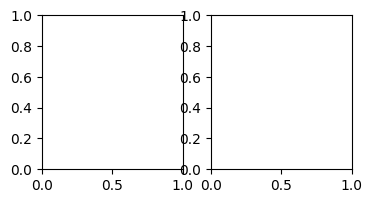

In [10]:
#tf is this
j = 0
x_list = []

#set range for what to plot here
r = range(0, 2, 1)
print(r)
fig, axis = plt.subplots(nrows=1, ncols=len(r), figsize=(len(r)*2, 2))

if True:
    for ax, m in zip(axis.ravel(), models[:1]):
        model = torch.load(m["path"], weights_only=False)
        x, _ = ddpm_diffusion_model.denoise(model=model, num_samples=1, channels=1, img_size=14)
        x_list.append(x)

        ax.imshow(x[0].detach().cpu().permute(1, 2, 0), cmap='gray')
        ax.set_title(f'epoch: {m["trained_epoch"]}', fontweight='bold')
        ax.axis(False)
        j += 1

    plt.show()

In [15]:
d = 3
x_list = []
ra = range(len(models))
# for i in ra:
#     model = torch.load(models[i]["path"], weights_only=False)
#
#     x, _ = ddpm.denoise(model=model, num_samples=d, channels=1, img_size=14)
#     x_list.append(F.interpolate(x, [28, 28]))
#
# X = torch.stack(x_list)
# denoised_images = f'X_d{d}_n{len(models)}.pt'
# torch.save(X, denoised_images)

In [11]:
cnn = torch.load("mnist_trained_cnn.pt", weights_only=False) #cnn trained on mnist (test-acc : 0.9878)
softmax = nn.Softmax(dim=1)

In [12]:
#X = torch.load(denoised_images)
#print(X.shape)

In [13]:
X = torch.load("X_d3_n50.pt")
print(X.shape)

torch.Size([50, 3, 1, 28, 28])


[0.9991108775138855,
 0.53242427110672,
 0.9790648818016052,
 0.9463239312171936,
 0.6565340161323547,
 0.9284401535987854,
 0.9976605772972107,
 0.7574537396430969,
 0.9999448657035828,
 0.987649142742157,
 0.9971825480461121,
 0.997502326965332,
 0.7263426184654236,
 0.9162529110908508,
 0.9299595355987549,
 0.995104968547821,
 0.9853105545043945,
 0.7633253931999207,
 0.9900221824645996,
 0.9921016693115234,
 0.7724084258079529,
 0.9839847087860107,
 0.876941978931427,
 0.9859929084777832,
 0.9656545519828796,
 0.9674620628356934,
 0.999865710735321,
 0.9992401003837585,
 0.9919517040252686,
 0.7757673859596252,
 0.8165470957756042,
 0.9952800273895264,
 0.9743621349334717,
 0.9951969981193542,
 0.999260663986206,
 0.8986188769340515,
 0.7127973437309265,
 0.9999380111694336,
 0.9971751570701599,
 0.997748076915741,
 0.9857852458953857,
 0.9998922944068909,
 0.991727352142334,
 0.9998610019683838,
 0.9997336268424988,
 0.6655868887901306,
 0.9980442523956299,
 0.9809867739677429,
 0

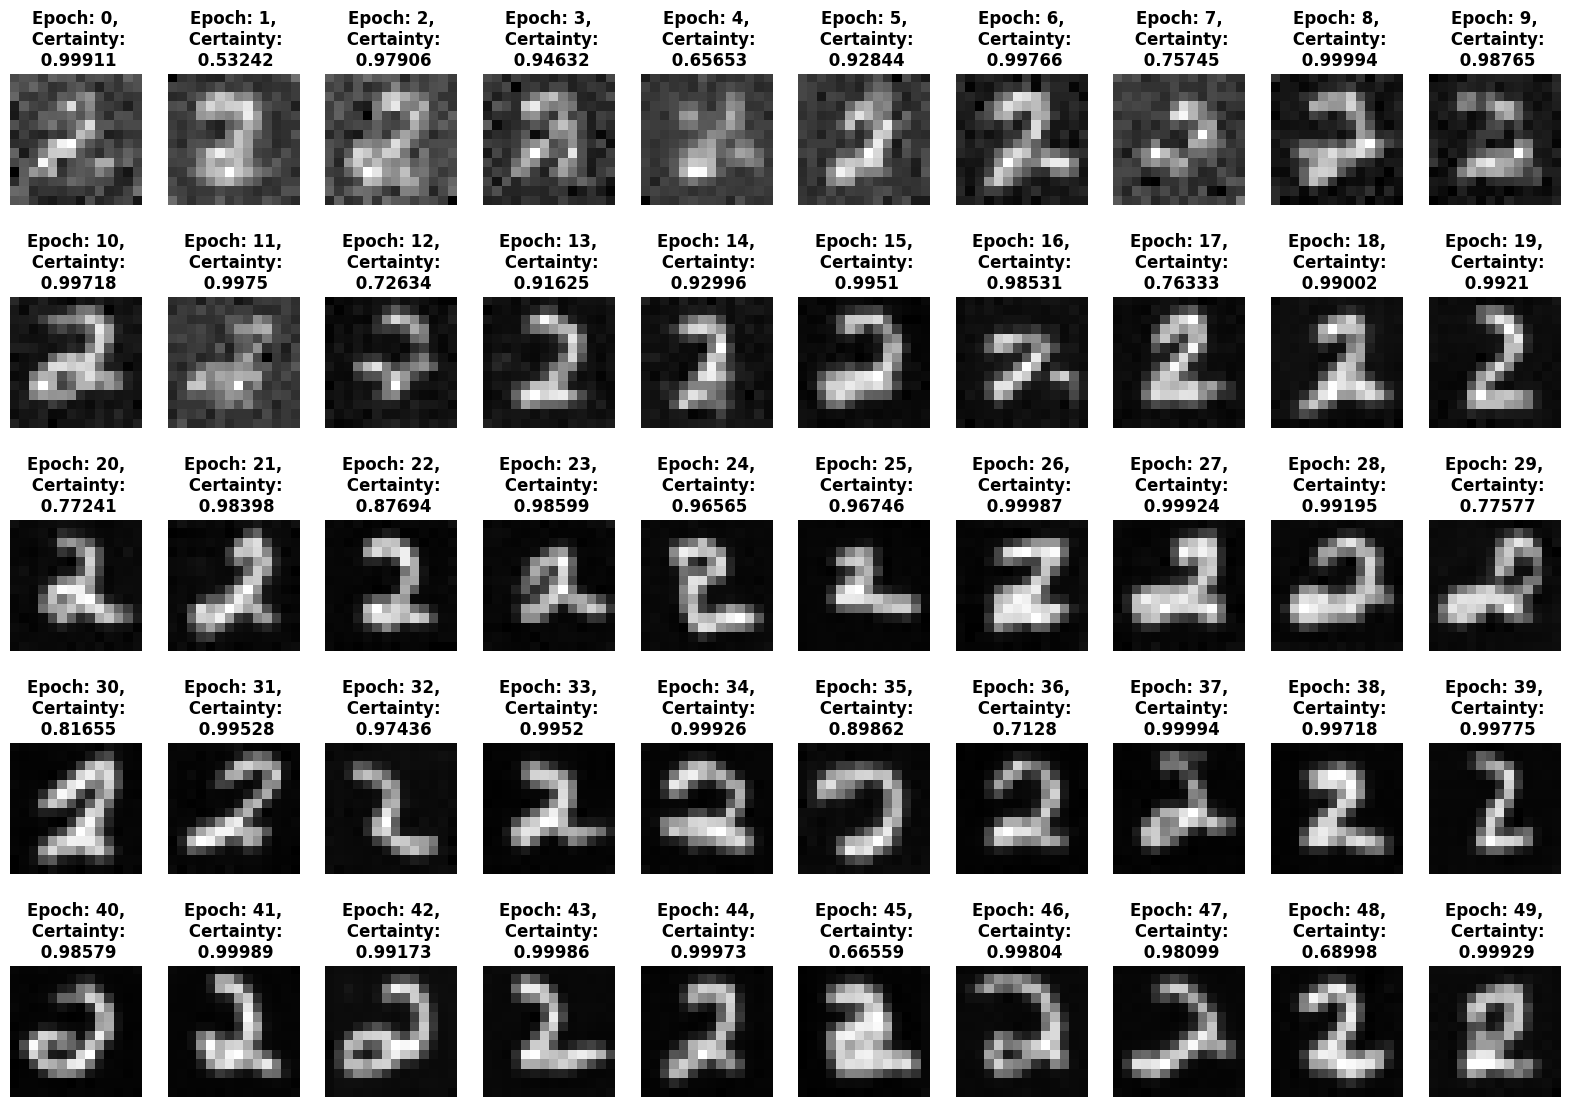

In [16]:
j = 0
fig, axis = plt.subplots(nrows=5, ncols=len(X)//5, figsize=((len(X)//5)*2, 14))

mean_correct_classification_prob = []
for ax, i, n in zip(axis.ravel(), range(len(X)), ra):
    x = X[i,...]
    out = cnn(x)
    prob = softmax(out)
    wanted_probs = prob[:,wanted_class]
    m = wanted_probs.mean().item()
    mean_correct_classification_prob.append(m)

    ax.imshow(x[0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Epoch: {n},\n Certainty:\n {round(m, 5)}', fontweight='bold')
    ax.axis(False)

    j += 1

mean_correct_classification_prob

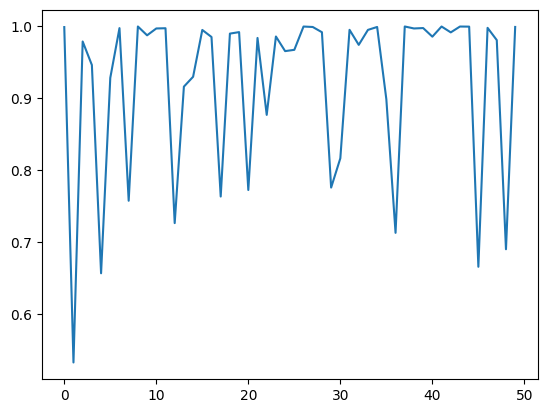

In [17]:
plt.plot(ra, mean_correct_classification_prob)